<a href="https://colab.research.google.com/github/souzamatt01/DNC-Desafio-7/blob/main/RID145536_Desafio7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Unterstanding:

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:


-Clientes que compram os mesmos produtos;

-Clientes que possuem a mesma frequência de compras;

-Clientes que gastam mais dinheiro em suas compras;


A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.





### **Etapa 01: Análise exploratória dos dados**

1. Carregue a base de dados;
2. Realize uma descrição estatística dos dados;
3. Visualize as distribuições e identifique a relevância das colunas para a análise;
4. Verifique a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.

In [ ]:
#Preparando as Bibliotecas
!pip install sidetable

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer, SilhouetteVisualizer


In [ ]:
#Caregando a base de dados
df = pd.read_csv('/content/data.csv.zip', encoding='latin-1')

In [ ]:
#Descrevendo os dados
print(df.head())
print(df.info())
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

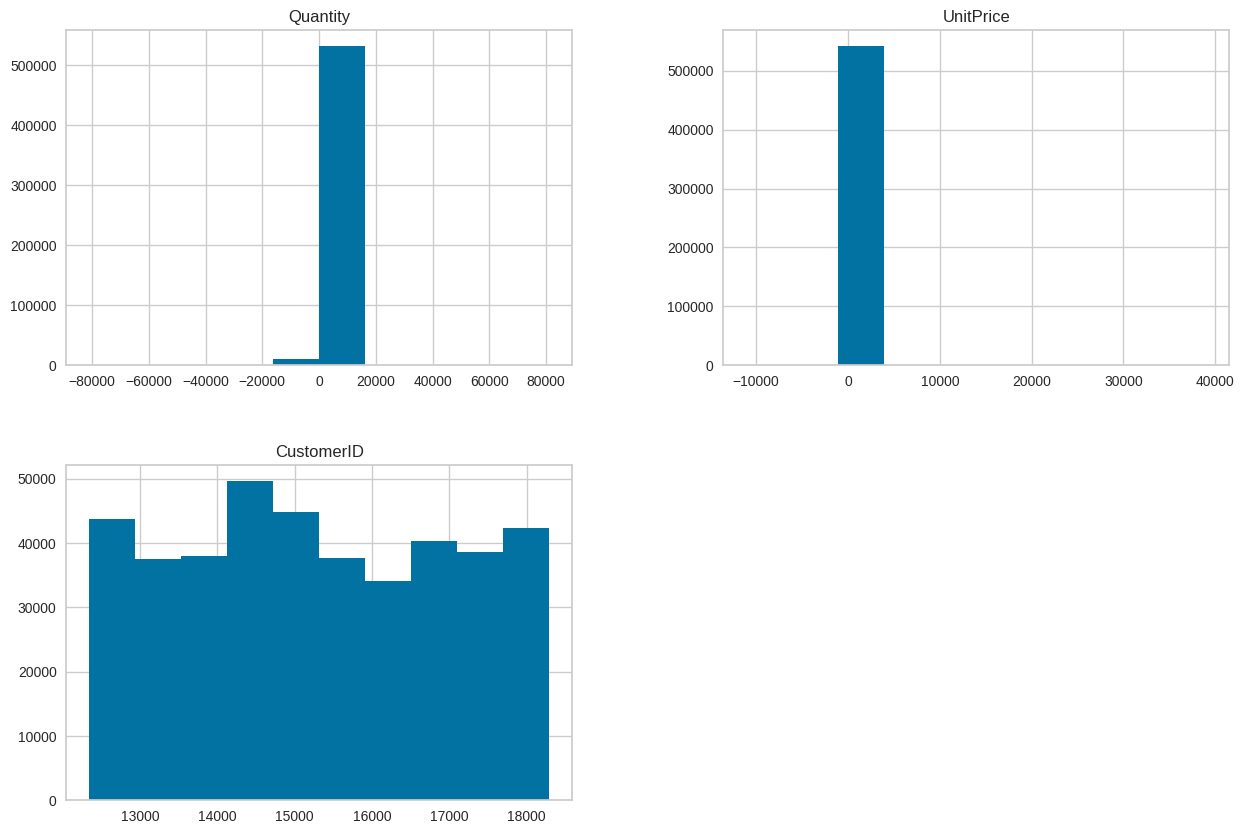

In [ ]:
#Visualização das distribuições e relevância das colunas
# Histograma das colunas numéricas
df.hist(figsize=(15,10))
plt.show()

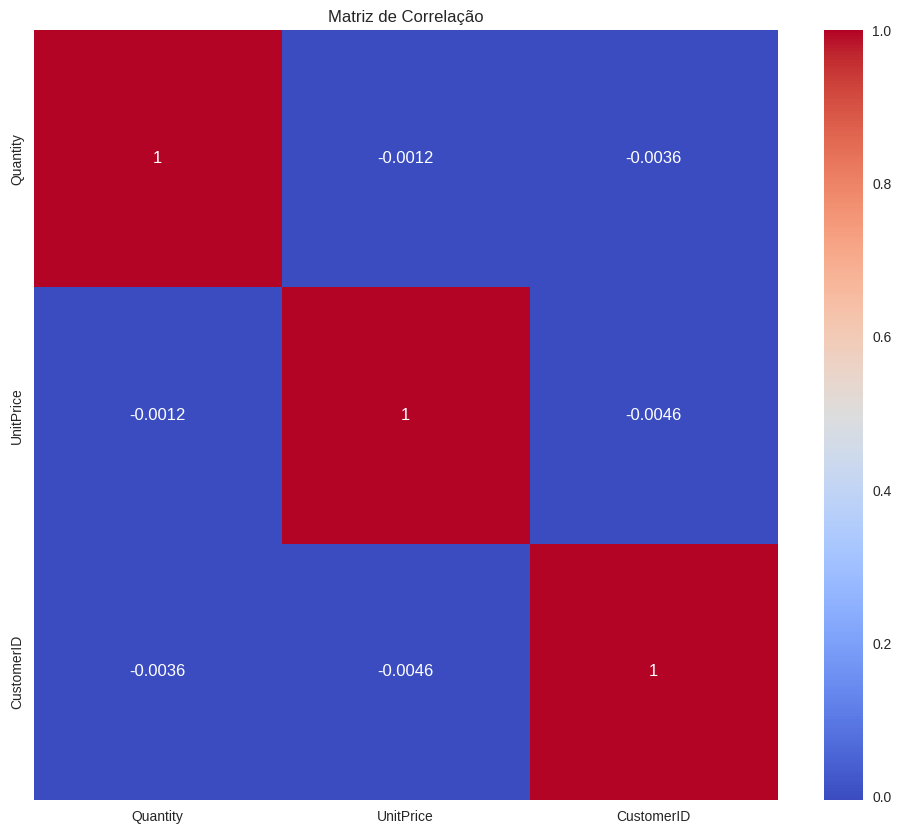

In [ ]:
# Matriz de correlação
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
#Verificando nulos
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
#Verificando duplicados
print(df.duplicated().sum())

5268


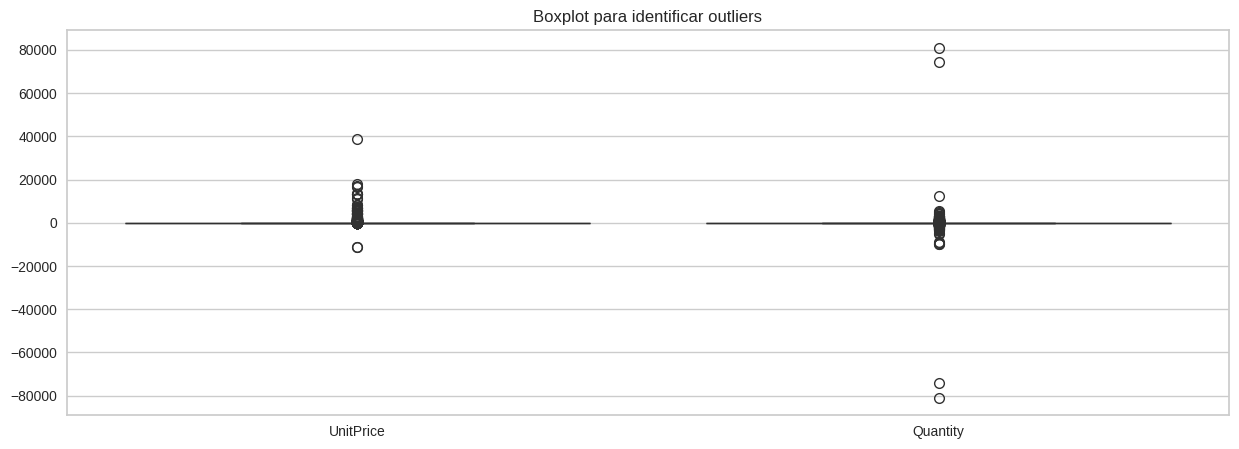

In [ ]:
# Análise de outliers com boxplot:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df[['UnitPrice', 'Quantity']])
plt.title('Boxplot para identificar outliers')
plt.show()

In [ ]:
# Outras inconsistências: análise das colunas categóricas,
# verificando a existência de valores inconsistentes ou não padronizados.
df[['InvoiceNo','StockCode','Description','CustomerID','Country']].nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
CustomerID,4372
Country,38


# Etapa 02: Pré-processamento dos dados

In [ ]:
# Removendo dados nulos
df.dropna(inplace=True)

In [ ]:
# Removendo dados duplicados
df.drop_duplicates(inplace=True)

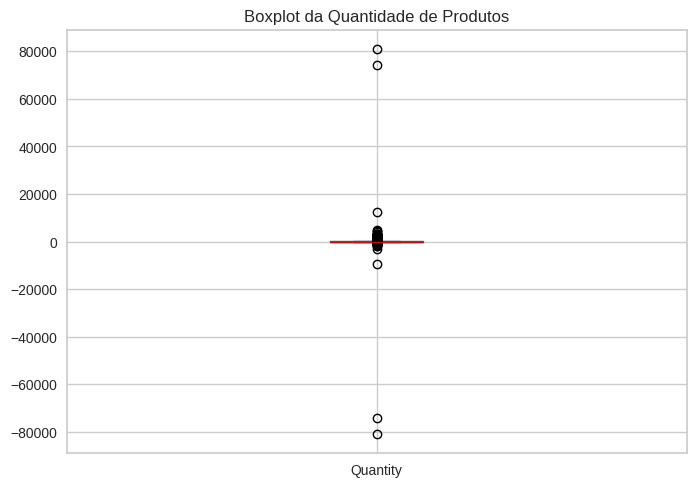

In [ ]:
#Checando os Outliers em 'Quantity'
df['Quantity'].plot.box()
plt.title('Boxplot da Quantidade de Produtos')
plt.show()

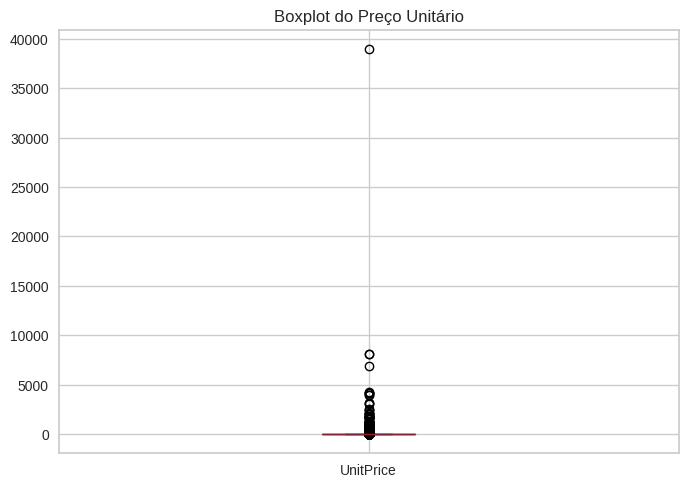

In [ ]:
#Checando os Outliers em 'UnitPrice'
df['UnitPrice'].plot.box()
plt.title('Boxplot do Preço Unitário')
plt.show()

In [ ]:
#Eliminando os Outliers e valore negativos
df.drop(df.query('Quantity >= 20000').index, axis=0, inplace=True)
df.drop(df.query('Quantity <= 0').index, axis=0, inplace=True)
df.drop(df.query('UnitPrice >= 8000').index, axis=0, inplace=True)
df.drop(df.query('UnitPrice <= 0').index, axis=0, inplace=True)

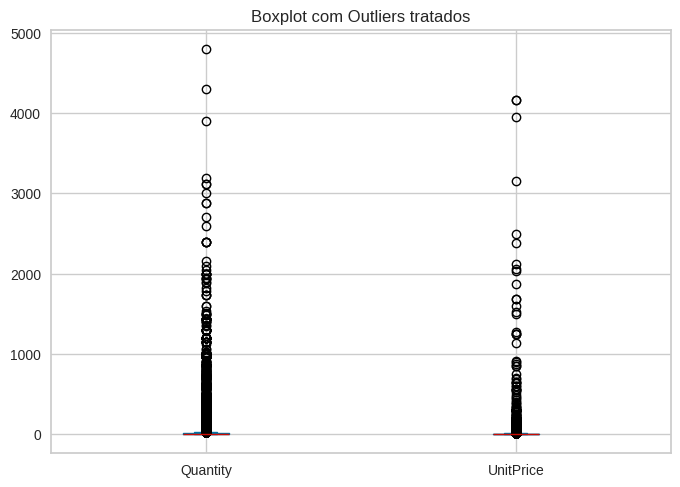

In [ ]:
#Checando os Outliers depois do tratamento
df[['Quantity', 'UnitPrice']].plot.box()
plt.title('Boxplot com Outliers tratados')
plt.show()

In [ ]:
#Adcionando a coluna "TotalPrice" para uso posterior:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [ ]:
#Corrgindo os tipos de dados
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object
TotalPrice,float64


In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceNo'] = df['InvoiceNo'].astype(int)
df['StockCode'] = df['StockCode'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Description'] = df['Description'].astype(str)
df['Country'] = df['Country'].astype(str)

In [ ]:
df.dtypes

,0
InvoiceNo,int64
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,int64
Country,object
TotalPrice,float64


# Etapa 03: Selecione um Algoritmo de Clusterização

In [ ]:
#Calculando o RFM:
NOW = dt.datetime(2011,12,10)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
rfmTable = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency',
                         'InvoiceNo': 'frequency',
                         'TotalPrice': 'monetary_value'}, inplace=True)
# Recency (Recência): Quantidade de dias desde a última compra
# Frequency (Frequência): Número total de compras
# Monetary (Valor monetário): Valor total gasto pelo cliente

In [ ]:
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12347,2,182,4310.00
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.40
12352,36,85,2506.04


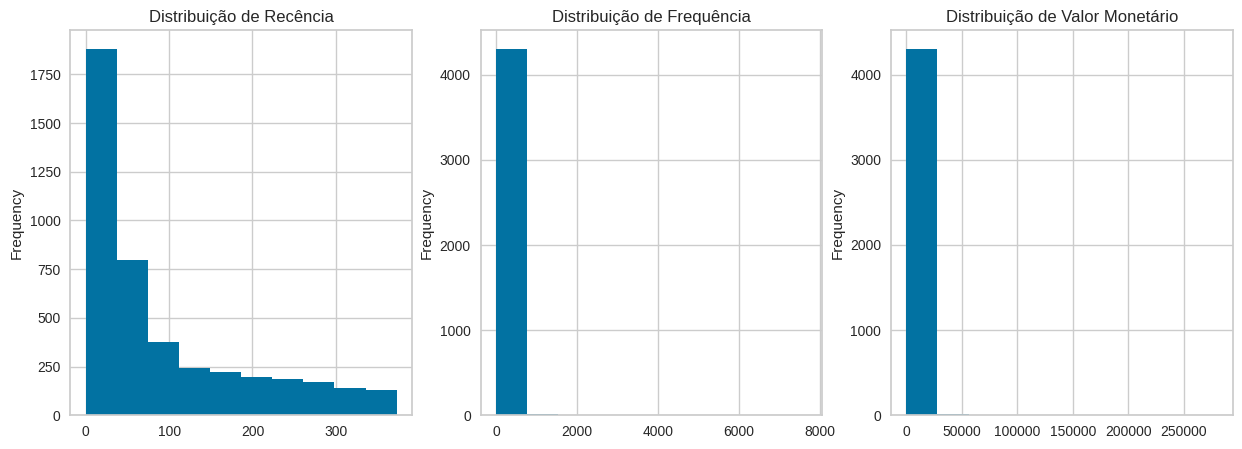

In [ ]:
#Plotando o histograma de cada uma das variáveis do RFM
plt.figure(figsize=(15, 5))
plt.subplot(131)
rfmTable['recency'].plot.hist()
plt.title('Distribuição de Recência')
plt.subplot(132)
rfmTable['frequency'].plot.hist()
plt.title('Distribuição de Frequência')
plt.subplot(133)
rfmTable['monetary_value'].plot.hist()
plt.title('Distribuição de Valor Monetário')
plt.show()

In [ ]:
#Aplicando o PowerTransformer
pt = PowerTransformer()
rfm_pt = rfmTable[['recency', 'frequency', 'monetary_value']]
rfm_pt_transformed = pt.fit_transform(rfm_pt)
rfm_pt_transformed = pd.DataFrame(rfm_pt_transformed, index=rfm_pt.index, columns=['recency', 'frequency', 'monetary_value'])

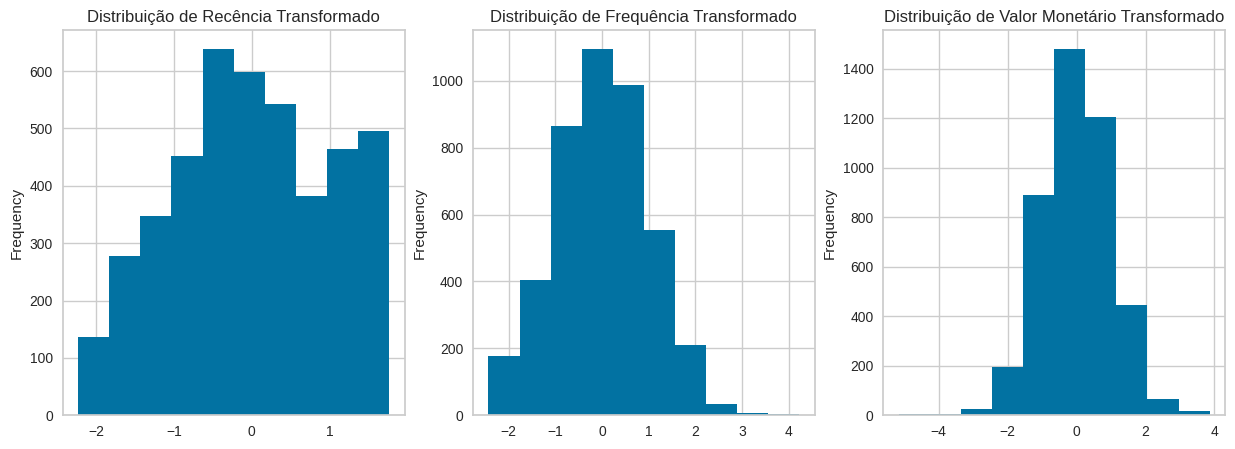

In [ ]:
#Visualizando os dados após a transformação:
plt.figure(figsize=(15, 5))
plt.subplot(131)
rfm_pt_transformed['recency'].plot.hist()
plt.title('Distribuição de Recência Transformado')
plt.subplot(132)
rfm_pt_transformed['frequency'].plot.hist()
plt.title('Distribuição de Frequência Transformado')
plt.subplot(133)
rfm_pt_transformed['monetary_value'].plot.hist()
plt.title('Distribuição de Valor Monetário Transformado')
plt.show()

In [ ]:
#Aplicando o StandartScaler:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_pt_transformed)
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm_pt_transformed.index, columns=['recency', 'frequency', 'monetary_value'])

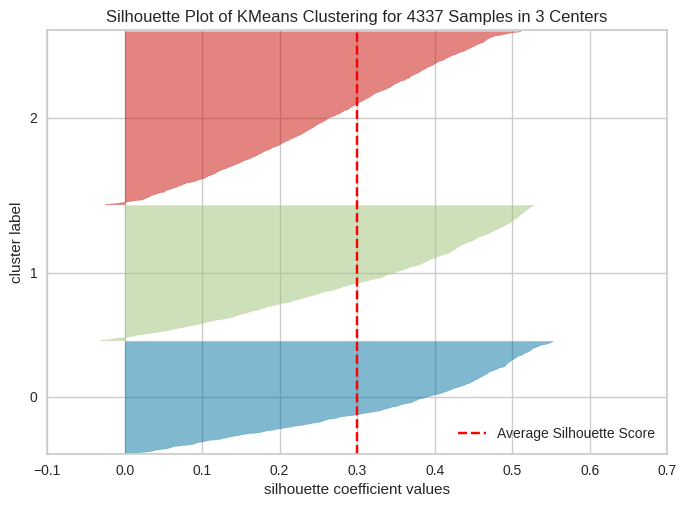

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4337 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Encontrando o número ideal de clusters usando o método Silhouette Score:
visualizer = SilhouetteVisualizer(KMeans(3, **kmeans_kwargs), colors='yellowbrick')
visualizer.fit(rfm_scaled_df)
visualizer.show()

In [ ]:
# Aplicando o KMeans com o número ideal de clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_scaled_df)

KMeans(n_clusters=3, random_state=42)

In [ ]:
# Adicionando os clusters ao DataFrame
rfmTable['cluster'] = kmeans.labels_

In [ ]:
# Exibindo os resultados
print(rfmTable.head())


            recency  frequency  monetary_value  cluster
CustomerID                                             
12347             2        182         4310.00        1
12348            75         31         1797.24        2
12349            18         73         1757.55        1
12350           310         17          334.40        0
12352            36         85         2506.04        1


# Etapa 04: Analise os clusters obtidos


In [ ]:
# Análise dos clusters
# Calculando as médias de cada variável para cada cluster
cluster_means = rfmTable.groupby('cluster').agg({'recency': 'mean', 'frequency': 'mean', 'monetary_value': 'mean'})
print(cluster_means)

            recency   frequency  monetary_value
cluster                                        
0        190.973254   14.950223      283.394785
1         19.780672  236.215966     5546.352580
2         65.877290   50.787896      917.159352


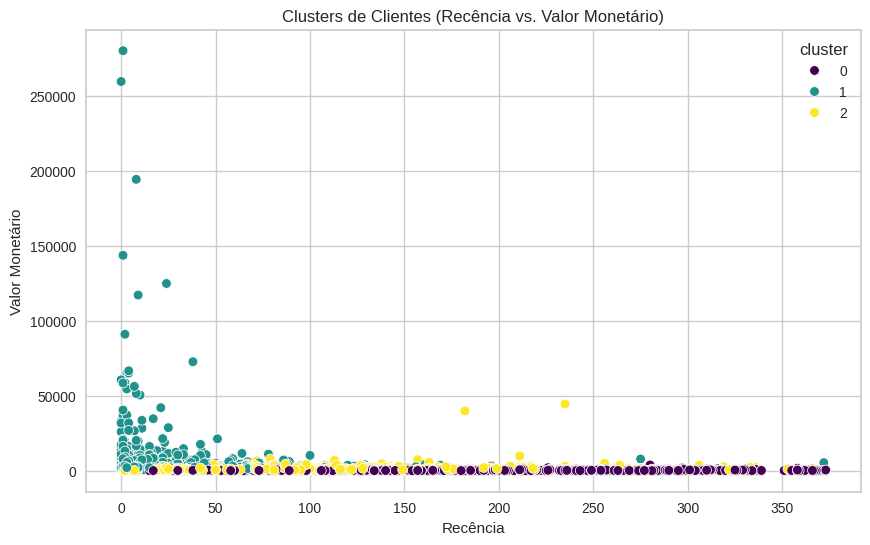

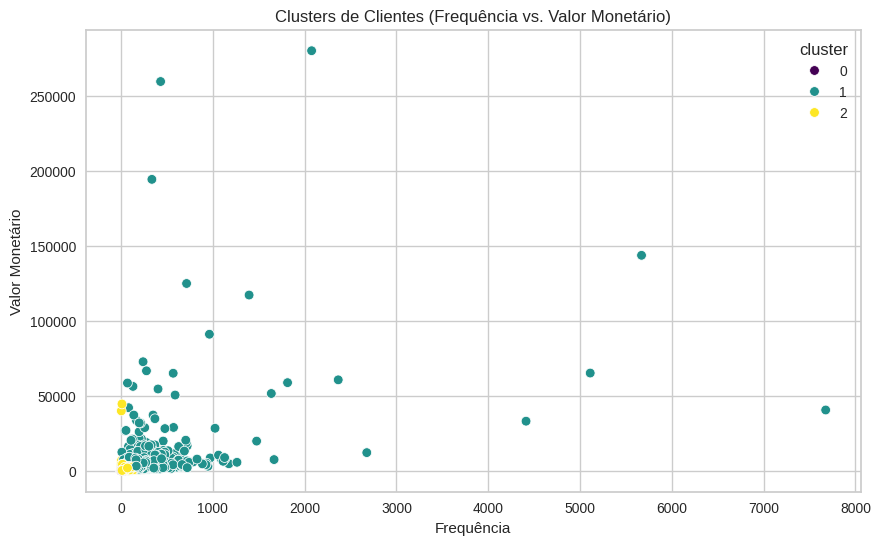

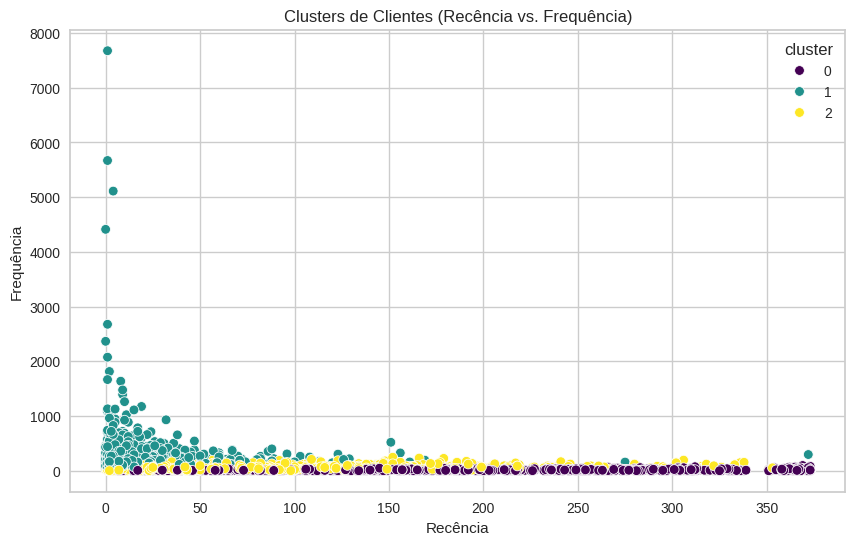

In [ ]:
# Plotando gráficos para auxiliar na análise
# Plotando gráficos para auxiliar na análise
# Gráfico de dispersão com os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='recency', y='monetary_value', hue='cluster', data=rfmTable, palette='viridis')
plt.title('Clusters de Clientes (Recência vs. Valor Monetário)')
plt.xlabel('Recência')
plt.ylabel('Valor Monetário')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary_value', hue='cluster', data=rfmTable, palette='viridis')
plt.title('Clusters de Clientes (Frequência vs. Valor Monetário)')
plt.xlabel('Frequência')
plt.ylabel('Valor Monetário')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='recency', y='frequency', hue='cluster', data=rfmTable, palette='viridis')
plt.title('Clusters de Clientes (Recência vs. Frequência)')
plt.xlabel('Recência')
plt.ylabel('Frequência')
plt.show()


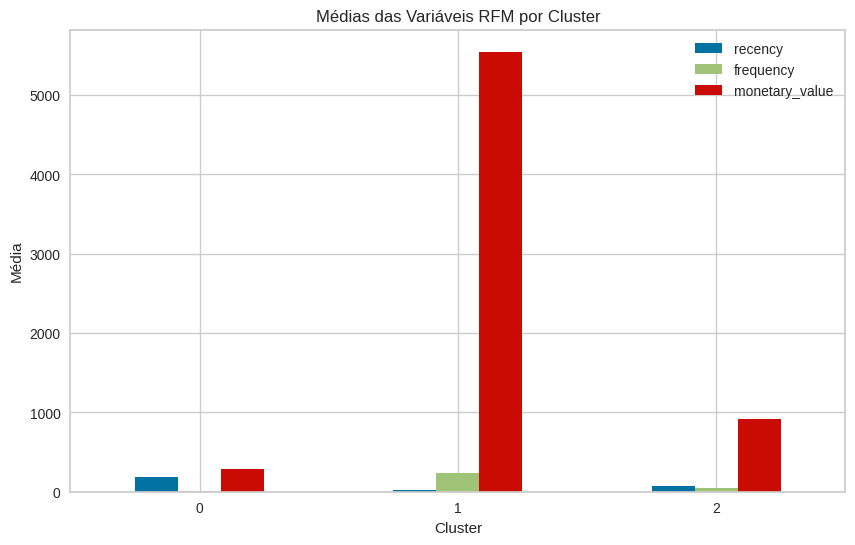

In [ ]:
# Gráfico de barras para comparar as médias de cada variável para cada cluster
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Médias das Variáveis RFM por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Média')
plt.xticks(rotation=0)
plt.show()

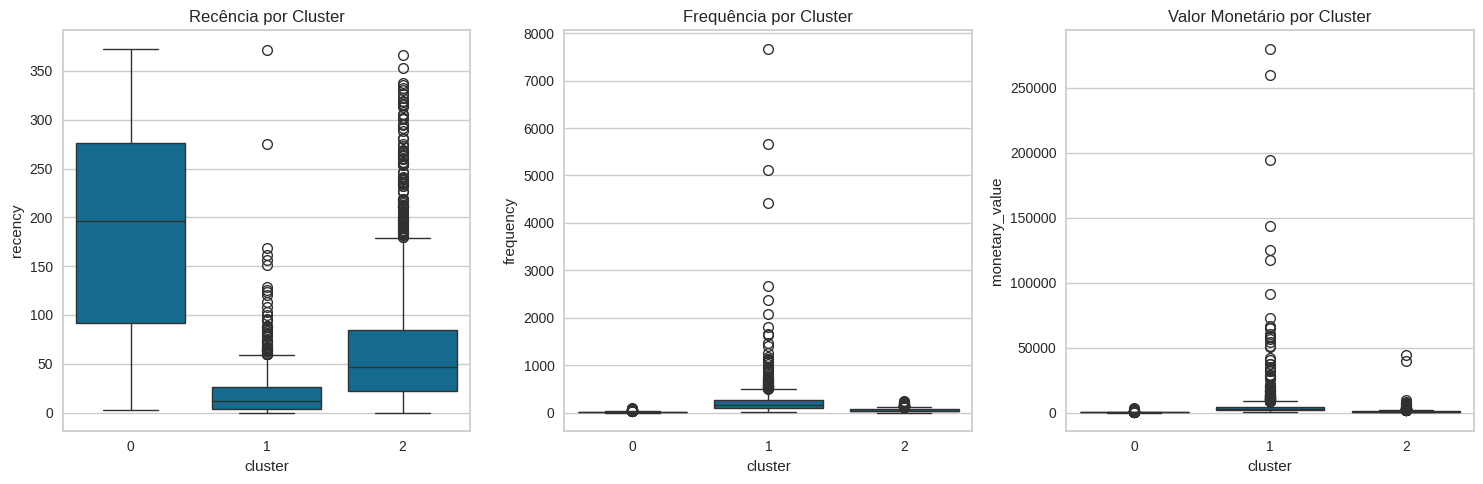

In [ ]:
# Boxplot para visualizar a distribuição de cada variável para cada cluster
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='recency', data=rfmTable)
plt.title('Recência por Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='frequency', data=rfmTable)
plt.title('Frequência por Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='monetary_value', data=rfmTable)
plt.title('Valor Monetário por Cluster')

plt.tight_layout()
plt.show()


#Etapa 05: Interpretação dos resultados obtidos

 Descrevendo o Perfil de cada Cluster:

 Analisando as médias de cada cluster (cluster_means) e os gráficos gerados
 (scatterplots e boxplots), podemos descrever o perfil de cada cluster:

 * Cluster 0:  Clientes com alta frequência de compra e alto valor monetário, porém com recência mediana.  São clientes fiéis e que gastam bastante, mas talvez precisem de estímulos para compras mais frequentes.




 * Cluster 1: Clientes com baixa recência, baixa frequência e baixo valor monetário. São clientes que não compram com frequência e gastam pouco, podendo ser considerados inativos ou potenciais perdas para a empresa.  




 * Cluster 2: Clientes com alta recência, frequência e valor monetário. São os melhores clientes da empresa, com compras recentes e alto gasto.  É importante manter esse grupo satisfeito e incentivar novas compras.


 Justificando a utilidade da Análise:

 A segmentação de clientes com base nos clusters permite direcionar as campanhas de marketing de forma mais eficiente e personalizada.  Por exemplo:

* Cluster 0 (Clientes fiéis, alto gasto, recência mediana): Oferecer programas de fidelização, promoções exclusivas, produtos premium ou lançamentos em primeira mão.
* Cluster 1 (Clientes inativos/potenciais perdas):  Campanhas de reativação, ofertas especiais para retorno, descontos significativos e email marketing focado na recuperação.
* Cluster 2 (Melhores clientes): Novas ofertas, sugestão de produtos relacionados a compras passadas, convites para eventos exclusivos e programas de recompensas.


Sugestão de possíveis ações:

Cluster 0:
*   Implementar um programa de pontos de fidelidade com recompensas exclusivas.
Oferecer cupons de desconto em compras futuras.
*   Criar um programa VIP com benefícios adicionais.
*   Criar campanhas de email marketing personalizadas, mostrando ofertas de produtos semelhantes aos já comprados.




Cluster 1:
*   Enviar emails personalizados com ofertas e produtos relacionados às últimas compras do cliente (se houver) ou de acordo com suas preferências.
*   Oferecer frete grátis em um determinado valor de compra.
*   Campanhas promocionais agressivas com descontos imperdíveis.
*   Criar uma campanha de recuperação com um brinde.


Cluster 2:
*   Oferecer produtos exclusivos ou lançamentos em primeira mão.
*   Oferecer um atendimento personalizado.
*   Enviar convites para eventos e workshops da empresa.
*   Criar uma campanha promocional com ofertas especiais para clientes VIP.
